<a href="https://colab.research.google.com/github/LuisCGit/6.484-reinforcement-learning/blob/main/Robustness_Check_Clean_up_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import scipy
from sklearn.pipeline import Pipeline
from scipy.stats import t, norm, multivariate_normal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import softmax
import sklearn.utils

from tqdm import tqdm

import datetime
import calendar

# Configuration
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_rows = 999
pd.options.display.max_columns = 300
pd.options.display.float_format = '{:.4f}'.format

np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.inf)

plt.rcParams['figure.figsize'] = [20, 12]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read in Data

In [2]:
months = ['october', 'november', 'december', 'january']
pillars = ['portfolio', 'promotion']
metrics = ['volume', 'net_revenue', 'maco']

month = months[3]
pillar = pillars[1]
metric = metrics[0]

# cols = ["inv_date", "store_id", "sku", "UEN", "DRV", "poc_segmentation", "sub_test_id", "test_group", "baseline_start_period", "baseline_end_period", "analysis_start_period", "analysis_end_period", "volume", "net_revenue", "maco"]

# !wget -O october_portfolio_200_days.csv https://www.dropbox.com/s/ce5mjf6b9txhss9/october_portfolio_200_days.csv?dl=0
# df = pd.read_csv("october_portfolio_200_days.csv").sort_values(by=['inv_date'])

# !wget -O november_portfolio_200_days.csv https://www.dropbox.com/s/ipl2dt2bzxcajwi/november_portfolio_200_days.csv?dl=0
# df = pd.read_csv("november_portfolio_200_days.csv").sort_values(by=['inv_date'])

# !wget -O december_portfolio_200_days.csv https://www.dropbox.com/s/nskg2kfvrpmp0dn/december_portfolio_200_days.csv?dl=0
# df = pd.read_csv("december_portfolio_200_days.csv").sort_values(by=['inv_date'])

# !wget -O december_promotion_200_days.csv https://www.dropbox.com/s/bg50sae864o2v9b/december_promotion_200_days.csv?dl=0
# df = pd.read_csv("december_promotion_200_days.csv").sort_values(by=['inv_date'])

!wget -O january_promotion_200_days.csv https://www.dropbox.com/s/wruefe4vb1u1f4g/january_promotion_200_days.csv?dl=0
df = pd.read_csv("january_promotion_200_days.csv").rename(columns={'Fecha_Pedido': 'inv_date'}).sort_values(by=['inv_date'])

sub_test_ids = np.unique(df["sub_test_id"]) 
print(sub_test_ids)
# len(sub_test_ids) # Oct 2021: 56; Nov 2021: 49; Dec 2021 (Portfolio): 19; Dec 2021 (Promo): 3; Jan 2022 (Promo): 1;

sub_test_id = sub_test_ids[0]
grouping_test='feature'
grouping_ctrl='random'


--2022-06-22 19:26:57--  https://www.dropbox.com/s/wruefe4vb1u1f4g/january_promotion_200_days.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wruefe4vb1u1f4g/january_promotion_200_days.csv [following]
--2022-06-22 19:26:58--  https://www.dropbox.com/s/raw/wruefe4vb1u1f4g/january_promotion_200_days.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc394ce9108c677e8b7c55e7ccd4.dl.dropboxusercontent.com/cd/0/inline/Bnt2-Wlg4n4KE8WsQWM7ARHUi1cI8SCeAa7_HxOC9V7-ObfRmX-sDoONMQagkcpnPY2L2FMBxh2c7SAiQWbLbvtsog7Wu6NcfMRXelRwcCkHbkDy3ViQFmdDgHHTr8cX0Rc-kIfw86esUxGrEIQLl1YOywzCQ1fGFTxHxScdiHXayQ/file# [following]
--2022-06-22 19:26:58--  https://uc394ce9108c677e8b7c55e7ccd4.dl.dropboxusercontent.com/cd/0/inline/Bnt2-Wlg4

In [3]:
df_copy = df

In [4]:
df['test_group'].value_counts()

1    5264720
0     608714
Name: test_group, dtype: int64

Define Functions

In [5]:
# preprocessing data

def experiment_information(df, sub_test_id, metric="volume"):
    """
    This function returns experiment-level information for a particular experiment
        
    @param experiment: name of experiment (sub_test_id)
    @param metric: metric of interest ('vol' or 'net_rev' or 'maco')
    
    @return: 
    'control_str_cnv',
    'test_str_cnv',
    'control_str',
    'test_str',
    'treatment_days',
    'test_post_sales',
    'control_post_sales',
    'avg_post_test',
    'avg_post_control'

    """

    df = df[df['sub_test_id'] == sub_test_id]
    df['baseline_start_period'] = pd.to_datetime(df['baseline_start_period'])
    df['baseline_end_period'] = pd.to_datetime(df['baseline_end_period'])
    df['analysis_start_period'] = pd.to_datetime(df['analysis_start_period'])
    df['analysis_end_period'] = pd.to_datetime(df['analysis_end_period'])
    df['inv_date'] = pd.to_datetime(df['inv_date'])
    
    baseline_start = df['baseline_start_period'].iloc[0]
    baseline_end = df['baseline_end_period'].iloc[0]
    T0 = (baseline_end - baseline_start).days + 1
    analysis_start = df['analysis_start_period'].iloc[0]
    analysis_end = df['analysis_end_period'].iloc[0]
    T1 = (analysis_end - analysis_start).days + 1

    # get relevant time period
    df = df[(df['inv_date'] >= baseline_start) & 
            (df['inv_date'] <= analysis_end)]
    
    df['treatment'] = df.test_group
    df['period'] = np.where(df['inv_date'].between(baseline_start, baseline_end, inclusive=True), 0, 1)
    

    control_str_cnv = len(df.query("treatment==0 & period==1").groupby('store_id')[metric].sum().where(lambda x : x>0).dropna())
    test_str_cnv = len(df.query("treatment==1 & period==1").groupby('store_id')[metric].sum().where(lambda x : x>0).dropna())
    control_str = len(df.query("treatment==0")['store_id'].unique())
    test_str = len(df.query("treatment==1")['store_id'].unique())
    treatment_days = T1
    test_post_sales = df.query("treatment==1 & period==1")[metric].sum()
    control_post_sales = df.query("treatment==0 & period==1")[metric].sum()
    avg_post_test = df.query("treatment==1 & period==1")[metric].mean()/T1
    avg_post_control = df.query("treatment==0 & period==1")[metric].mean()/T1
    
    # remove control & treatment stores with 0 volume during treatment period
    df = df.drop(df[(df.volume == 0) & (df.period == 1)].index)
    
    experiment_info = {
        'sub_test_id' : sub_test_id,
        'metric': metric,
        'control_str_cnv': control_str_cnv,
        'test_str_cnv': test_str_cnv,
        'control_str': control_str, 
        'test_str': test_str,
        'treatment_days': treatment_days,
        'test_post_sales': test_post_sales,
        'control_post_sales': control_post_sales,
        'avg_post_test': avg_post_test,
        'avg_post_control': avg_post_control,
    }

    return experiment_info, df, T0, T1

In [58]:
# diff-in-diff functions

def diff_in_diff(df,sub_test_id,T0,T1,metric="volume"):
    """
    extract data from dataframe for diff-in-diff analysis
    diff-in-diff regression

    """
    # treatment group time difference
    test_pre = df.query("treatment==1 & period==0")[metric].mean()
    test_post = df.query("treatment==1 & period==1")[metric].mean()
    # control group time difference
    ctrl_pre = df.query("treatment==0 & period==0")[metric].mean()
    ctrl_post = df.query("treatment==0 & period==1")[metric].mean()
    # diff-in-diff
    diff_in_diff_value = (test_post - test_pre) - (ctrl_post - ctrl_pre)
    
    # DiD Regression Model
    try:
        formula = metric + ' ~ period*treatment'
        did_model = smf.ols(formula, data=df).fit()
        
        # DiD Results
        avg_treatment_effect = did_model.params["period:treatment"]
        p_value = did_model.pvalues["period:treatment"]
        CI_lower = did_model.conf_int().loc["period:treatment"][0]
        CI_upper = did_model.conf_int().loc["period:treatment"][1]
        SE = did_model.bse["period:treatment"] #SE = (CI_upper-avg_treatment_effect)/1.96

        num_test_stores = len(df.query("treatment==1")['store_id'].unique())
        avg_perc_lift = avg_treatment_effect/test_post
        total_lift = avg_treatment_effect*num_test_stores*T1
        total_CI_lower = CI_lower*num_test_stores*T1
        total_CI_upper = CI_upper*num_test_stores*T1
        
        experiment_did_result = {
                'diff_in_diff_value': diff_in_diff_value,
                'avg_lift' : avg_treatment_effect,
                'pvals' : p_value,
                'conf_lower' : CI_lower,
                'conf_higher' : CI_upper,
                'SE': SE,
                'percentage_lift': avg_perc_lift,
                'total_increment': total_lift,
                'confidence_lower': total_CI_lower,
                'confidence_higher': total_CI_upper,
            }
        
        return experiment_did_result
    
    except ValueError:
        print(sub_test_id)
        #return None, None, None, None, None, None, None, None, None, None
        return {}

def extract_did_data(df,metric="volume"):
    """
    extract data from dataframe for synthetic control analysis

    """
    baseline_start = df['baseline_start_period'].iloc[0]
    baseline_end = df['baseline_end_period'].iloc[0]
    analysis_start = df['analysis_start_period'].iloc[0]
    analysis_end = df['analysis_end_period'].iloc[0]

    # test_avg = df.query("test_group==1").groupby('inv_date')[metric].mean()
    # for date in pd.date_range(start=baseline_start,end=analysis_end): #fill missing dates in
    #     if not(date in list(test_avg.index)):
    #         test_avg = pd.concat([test_avg, pd.Series([0.0], index=[date])])
    # test_avg.sort_index(inplace=True)
    # did_Y1 = test_avg.values.reshape(-1, 1)

    # ctrl_avg = df.query("test_group==0").groupby('inv_date')[metric].mean()
    # for date in pd.date_range(start=baseline_start,end=analysis_end): #fill missing dates in
    #     if not(date in list(ctrl_avg.index)):
    #         ctrl_avg = pd.concat([ctrl_avg, pd.Series([0.0], index=[date])])
    # ctrl_avg.sort_index(inplace=True)
    # did_Y0 = ctrl_avg.values.reshape(-1, 1)

    # get treatment group data in long format
    treatment_data = df.query("test_group==1").groupby(['inv_date','store_id'],as_index=False)[metric].mean()
    # pivot to wide format and fill in missing dates to correct for dimension "T periods"
    treatment_data_wide = treatment_data.pivot_table(index="inv_date", columns='store_id', values=metric, aggfunc=np.mean)
    for date in pd.date_range(start=baseline_start,end=analysis_end): #fill missing dates in
      if not(date in list(treatment_data_wide.index)):
        treatment_data_wide.loc[date] = pd.Series(np.nan, index=treatment_data_wide.columns)
    treatment_data_wide.sort_index(inplace=True)

    # repeat for control group data
    control_data = df.query("test_group==0").groupby(['inv_date','store_id'],as_index=False)[metric].mean()
    control_data_wide = control_data.pivot_table(index="inv_date", columns='store_id', values=metric, aggfunc=np.mean)
    for date in pd.date_range(start=baseline_start,end=analysis_end): #fill missing dates in
      if not(date in list(control_data_wide.index)):
        control_data_wide.loc[date] = pd.Series(np.nan, index=control_data_wide.columns)
    control_data_wide.sort_index(inplace=True)

    return control_data_wide, treatment_data_wide

def diff_in_diff_algo(Y1,Y0,T1,T0):
    """
    extract data from dataframe for diff-in-diff analysis
    diff-in-diff regression

    """
    # treatment group time difference
    test_pre = Y1[:T0,].mean()
    test_post = Y1[T0:,].mean()
    # control group time difference
    ctrl_pre = Y0[T0:,].mean()
    ctrl_post = Y0[T0:,].mean()
    # diff-in-diff
    avg_lift = (test_post - test_pre) - (ctrl_post - ctrl_pre)
    did_counterfactual = Y0[T0:,] + avg_lift

    return avg_lift, did_counterfactual

def diff_in_diff_inference(Y1,Y0,T1,T0):
    """
    input: "converted" Y1 (T x num_treatment_stores) and Y0 (T x num_control_stores) to match SC input format
    output: results_dict with avg_lift, pvals, conf_lower, conf_higher, SE, and constructed DiD counterfactual in post treatment period
    """
    # check input types
    if isinstance(Y0, pd.DataFrame):
      Y0 = Y0.to_numpy()
      # print(type(Y0))
    if isinstance(Y1, pd.DataFrame):
      Y1 = Y1.to_numpy()
      # print(type(Y1))
    # convert array to dataframe
    # subset Y0, Y1 by T0, T1 to add pre vs post period, test vs control flag
    test_pre_df = pd.DataFrame(Y1[:T0,])
    test_post_df = pd.DataFrame(Y1[T0:,])
    ctrl_pre_df = pd.DataFrame(Y0[T0:,])
    ctrl_post_df = pd.DataFrame(Y0[T0:,])

    # test_pre_df_long = pd.melt(test_pre_df, value_vars=test_pre_df.columns, value_name = metric, ignore_index=False).dropna().assign(treatment = 1, period = 0)
    # test_post_df_long = pd.melt(test_post_df, value_vars=test_post_df.columns, value_name = metric, ignore_index=False).dropna().assign(treatment = 1, period = 1)
    # ctrl_pre_df_long = pd.melt(ctrl_pre_df, value_vars=ctrl_pre_df.columns, value_name = metric, ignore_index=False).dropna().assign(treatment = 0, period = 0)
    # ctrl_post_df_long = pd.melt(ctrl_post_df, value_vars=ctrl_post_df.columns, value_name = metric, ignore_index=False).dropna().assign(treatment = 0, period = 1)


    test_pre_df_long = pd.melt(test_pre_df, value_vars=test_pre_df.columns, value_name = metric, ignore_index=False).assign(treatment = 1, period = 0)
    test_post_df_long = pd.melt(test_post_df, value_vars=test_post_df.columns, value_name = metric, ignore_index=False).assign(treatment = 1, period = 1)
    ctrl_pre_df_long = pd.melt(ctrl_pre_df, value_vars=ctrl_pre_df.columns, value_name = metric, ignore_index=False).assign(treatment = 0, period = 0)
    ctrl_post_df_long = pd.melt(ctrl_post_df, value_vars=ctrl_post_df.columns, value_name = metric, ignore_index=False).assign(treatment = 0, period = 1)


    # combine treatment and control data
    reg_data = pd.concat([test_pre_df_long, test_post_df_long, ctrl_pre_df_long, ctrl_post_df_long])
    # diff-in-diff regression
    formula = metric + ' ~ period*treatment'
    did_model = smf.ols(formula, data=reg_data).fit()
    # print(did_model.summary())

    # DiD Results
    avg_treatment_effect = did_model.params["period:treatment"]
    p_value = did_model.pvalues["period:treatment"]
    CI_lower = did_model.conf_int().loc["period:treatment"][0]
    CI_upper = did_model.conf_int().loc["period:treatment"][1]
    SE = did_model.bse["period:treatment"] #SE = (CI_upper-avg_treatment_effect)/1.96

    results_dict = {
    'avg_lift' : avg_treatment_effect,
    'pvals' : p_value,
    'conf_lower' : CI_lower, 
    'conf_higher' : CI_upper,
    'SE' : SE,
    }

    # did_counterfactual = np.nanmean(Y0[T0:,], axis=1) + avg_treatment_effect
    #did_counterfactual = np.nanmean(Y0, axis=1) + np.concatenate((np.zeros(T0),np.ones(T1)*avg_treatment_effect))
    did_counterfactual = np.nanmean(Y0, axis = 1)

    # return avg_lift & inference, did_counterfactual
    return results_dict, did_counterfactual

In [14]:
# Synthetic control functions

def df_long_to_wide(df,metric="volume"):
    """
    convert dataframe to wide format and return number of (baseline/treatment) analysis periods

    """
    df['inv_date'] = pd.to_datetime(df.inv_date, format='%Y-%m-%d %H:%M:%S')
    df_wide = (
    df
    .assign(inv_date_str = df['inv_date'].dt.strftime('%Y-%m-%d'),
            date_name = lambda x: metric + '_' + x['inv_date_str'],
            met = df[metric])
    #.pivot_table(index=['sku', 'sub_test_id', 'test_group'], columns='date_name', values='met')
    .pivot_table(index=['store_id', 'sub_test_id', 'test_group'] + ['DRV', 'UEN', 'poc_segmentation'], columns='date_name', values='met')
    .reset_index()    
    )
    num_period = len(df_wide.filter(regex=metric).columns)

    return df_wide, num_period

def metric_rolling_avg(df,metric="volume",window=7):
    """
    smooth metric values with 7-day rolling average

    """
    #df_identifier = df.loc[:,'store_id':'test_group']
    df_non_metric = df.drop(df.filter(regex=metric).columns,axis=1)
    df_metric = df.filter(regex = metric)
    T = df_metric.shape[1]
    df_rolling_avg = df_metric.rolling(window, min_periods=1, axis = 1).mean()
    df_final = pd.concat([df_non_metric, df_rolling_avg], axis= 1)

    return df_final, T

def group_stores(df,store_type,metric,T0,grouping=None,N=0):
    if store_type == "test":
      df = df[df['test_group'] == 1]
    else:
      assert(store_type == "control")
      df = df[df['test_group'] == 0]

    if grouping == "feature":
      print("feature")
      Y = df.groupby(by=['DRV', 'UEN', 'poc_segmentation'],as_index=False).mean()
      Y_feats = pd.get_dummies(Y[['DRV', 'UEN', 'poc_segmentation']])
    elif grouping == "random":
      print("random")
      num_stores = df.shape[0]
      assert(num_stores >= N, "specified number of groups larger than number of stores")
      group_size = num_stores // N 
      remainder = num_stores % N
      idx = []
      for i in range(N):
        idx = idx + [str(i)]*group_size
      idx = idx + [str(N)]*remainder
      np.random.shuffle(idx)
      Y = pd.get_dummies(df,columns=['DRV', 'UEN', 'poc_segmentation'],dtype=np.float64)
      Y["group"] = idx 
      Y = Y.groupby(by="group",as_index=True).mean()
      Y_feats = Y.filter(regex="^(DRV|UEN|poc_segmentation)")
    else:
      print("default")
      if store_type == "test": #default behaviour for test is to average all test stores
        Y = pd.get_dummies(df,columns=['DRV', 'UEN', 'poc_segmentation'],dtype=np.float64)
        Y = pd.DataFrame([Y.drop(columns=['store_id', 'sub_test_id']).mean(axis=0)])
      else: #default behaviour for control is to do no aggregation at all on control stores
        Y = df
      Y_feats = Y.filter(regex="^(DRV|UEN|poc_segmentation)")
    Y_metric = Y.filter(regex = metric)
    Y_feats['avg_'+ metric] = Y_metric.mean(axis = 1)
    Y_feats['pre_avg_'+ metric] = Y_metric.iloc[:,:T0].mean(axis = 1)
    # Y_feats['post_avg_'+ metric] = Y_metric.iloc[:,T0:].mean(axis = 1)
    Y_weekly_feats = Y_metric.groupby(np.arange(len(Y_metric.columns))//7, axis=1).mean().add_prefix('7day_avg_'+ metric)
    Y_feats = pd.concat([Y_feats, Y_weekly_feats], axis= 1)
    # Y_weekly_feats_change = Y_weekly_feats.pct_change(axis='columns', periods=1).drop(columns=Y_weekly_feats.columns[0], axis = 1).add_prefix('perc_change_').fillna(0).replace([np.inf, -np.inf], 0)
    # Y_feats = pd.concat([Y_feats, Y_weekly_feats, Y_weekly_feats_change], axis= 1)
    Y = np.array(Y_metric).transpose()
    return Y, Y_feats

def extract_sc_data(df,T0,T1,metric="volume",grouping_ctrl = None,grouping_test=None,N=0):
    """
    extract data from dataframe for synthetic control analysis

    """
    baseline_start = df['baseline_start_period'].iloc[0]
    baseline_end = df['baseline_end_period'].iloc[0]
    analysis_start = df['analysis_start_period'].iloc[0]
    analysis_end = df['analysis_end_period'].iloc[0]
    
    df = df_long_to_wide(df,metric)[0]
    df_metric = df.filter(regex = metric)
    overall_sparsity = df_metric.isna().sum().sum()/(df_metric.shape[0]*df_metric.shape[1])
    df = df.fillna(0)
    
    for date in pd.date_range(start=baseline_start,end=analysis_end): #fill missing dates in
        colname = metric + '_' + date.strftime("%Y-%m-%d")
        if not(colname in df.columns):
            df[colname] = 0.0

    df = df.reindex(sorted(df.columns), axis=1)
    df_wide_raw = df
    df, T = metric_rolling_avg(df,metric)
    df_metric = df.filter(regex = metric)
    smoothed_sparsity = (df_metric == 0).sum().sum()/(df_metric.shape[0]*df_metric.shape[1])

    Y1 = np.array(df[df['test_group'] == 1].filter(regex = metric)).transpose()
    num_test_stores = Y1.shape[1] 

    Y1, Y1_feats = group_stores(df,"test",metric,T0,grouping=grouping_test,N=N)
    Y0, Y0_feats = group_stores(df,"control",metric,T0,grouping=grouping_ctrl,N=N)

    Y0_sparsity = (Y0 == 0).sum().sum()/(Y0.shape[0]*Y0.shape[1])
    SC_control_stores = Y0.shape[1]
    print("T0: ", T0)
    print("T1: ", T1)
    print("T: ", T)
    assert(T0+T1==T)
    return T0, T1, Y0, Y1, num_test_stores, SC_control_stores, overall_sparsity, smoothed_sparsity, Y0_sparsity, df_wide_raw, Y0_feats, Y1_feats

In [15]:
def sc_regression(Y1,Y0,select):
    """
    given some treatment outcome data as well as some control outcome data, this function
    creates a linear combination of control units in Y0 which approximates the treatment unit in Y1.
    
    @param Y1: outcome data for treated unit (T x 1 vector)
    @param Y0: outcome data for control units (T x J matrix)
    @param select: which features (control stores) to select for the synthetic control (list of indices)
    
    @return OLS_estimator: fitted LinearRegression object
    """
    OLS_estimator = LinearRegression(fit_intercept=True)
    OLS_estimator.fit(Y0[:,select],Y1)
    return OLS_estimator

def sc_feature_selection(Y1,Y0,T0,alphas = np.logspace(-5,10,20, base=2.0)):
    """
    given some treatment outcome data as well as some control outcome data, this function
    uses Lasso to select which features (control stores) to use for the synthetic control
    
    @param Y1: outcome data for treated unit (T x 1 vector)
    @param Y0: outcome data for control units (T x J matrix)
    @param T0: number of pre-treatment (baseline) time periods 
    @param alphas: values to try for Lasso regularization strength
    
    @return ans_select: list of indices of stores to select for synthetic control
    
    """
    num_train = int(math.ceil(T0/2))
    X_train = Y0[0:num_train,:]; y_train = Y1[0:num_train] # weeks pre-treatment to train 
    X_val = Y0[num_train:T0,:]; y_val = Y1[num_train:T0] # weeks pre-treatment to validate 
    if (Y0.shape[1] == 0):
        print("oops, no control stores for this experiment")
        return np.array([]), -np.inf
    max_score = -np.inf
    ans_select = np.array([])
    for alpha in alphas:
        lasso_estimator = Lasso(alpha=alpha, fit_intercept=True)
        lasso_estimator.fit(X_train, y_train)
        select = (lasso_estimator.coef_ != 0)
        if (np.sum(select) == 0):
            #print("oops, no control stores selected by lasso")
            continue
        OLS_estimator = LinearRegression(fit_intercept=True)
        OLS_estimator.fit(X_train[:, select], y_train)
        score = OLS_estimator.score(X_val[:, select], y_val)
        if (score > max_score):
            max_score = score
            ans_select = select
    #try with normal linear regression
    p = X_train.shape[1]
    if p > T0:
        perm = np.random.permutation(p)
        select = np.array([False for i in range(p)])
        select[perm[:T0]] = True
    else:
        select = np.array([True for i in range(p)]) 
    OLS_estimator = LinearRegression(fit_intercept=True)
    OLS_estimator.fit(X_train[:, select], y_train)
    score = OLS_estimator.score(X_val[:, select], y_val)
    if (score > max_score):
        max_score = score
        ans_select = select
    #----added to avoid underdetermined linear regression
    num_selected = np.sum(ans_select)
    if num_selected > T0: #if Lasso selects too many features, unselect some of them 
        true_idx = np.where(ans_select == True)[0]
        num_extra = num_selected - T0 + 2
        print("num_extra: ", num_extra)
        selected_idx = true_idx[np.random.permutation(len(true_idx))[:num_extra]]
        print("selected_idx: ", selected_idx)
        ans_select[selected_idx] = False
    print("num features selected after correction: ", np.sum(ans_select))
    #----
    return ans_select, max_score

def sc_OLS_inference(Y1,Y0,T1,T0,include_val_score=True):
    """
    given some treatment outcome data as well as some control outcome data, this function
    creates a synthetic control and estimates the average treatment effect of the intervention
    
    @param Y1: outcome data for treated unit (T x 1 vector)
    @param Y0: outcome data for control units (T x J matrix)
    @param T0: number of pre-treatment (baseline) time periods 
    @param T1: number of treatment time periods 
    
    @return tau_hat: estimated average treatment effect
    @return one_sided_p_val: one sided p-value for the null hypothesis tau_hat = 0 
    @return two_sided_p_val: two sided p-value for the null hypothesis tau_hat = 0 
    @return lb, ub: lower and upper bounds for confidence interval for tau_hat
    @return se_hat: estimated standard error of tau hat
    @synthetic_control: sales predicted by synthetic control
    """
    def parallel_trends_check(Y1,Y0,T0):
      """

      """
      num_train = int(math.ceil(T0/2))
      beta0 = np.mean(Y1[:num_train] - np.mean(Y0[:num_train,:],axis=1))
      val_score = 0
      return beta0, val_score

    assert(T0+T1 == len(Y1))
    
    select, max_score = sc_feature_selection(Y1,Y0,T0) #get features from lasso
    if select.size == 0: #if no controls, skip
        return {'pvals' : -1}

    
    T = T0 + T1 #total number of time periods
    Y1_pre  = Y1[:T0]
    Y0_pre  = Y0[:T0,select]
    Y1_post = Y1[(T0):]
    Y0_post = Y0[(T0):,select]
    Y0_all = np.concatenate((Y0_pre,Y0_post),axis=0)

    X = Y0_pre
    X = sm.add_constant(X)

    y = Y1_pre

    # DiD
    num_train = int(math.ceil(T0/2))
    d = np.mean(Y1_pre[:num_train]) - np.mean(np.mean(Y0_pre[:num_train],axis=1))
    did_val_pred = np.mean(np.mean(Y0_pre[num_train:], axis=1)) + d
    mse_did = np.sum((Y1_pre[num_train:] - did_val_pred) ** 2)
    ss = np.sum((Y1_pre[num_train:] - np.mean(Y1_pre[:num_train])) ** 2)
    r2_val_did = 1 - mse_did / ss
    
    if max_score > 0:
      model = sm.OLS(y,X)
    else:
      y = Y1_pre - np.mean(Y0_pre,axis=1)
      y = pd.DataFrame(y,columns=['y'])
      model = smf.ols(formula='y ~ 1', data=y)

    results = model.fit()
    
    r2 = results.rsquared

    w = np.mean(Y0_post, axis=0)

    t_test_index = np.concatenate(([1], w))
    
    b = np.mean(Y1_post)
    if max_score > 0:
      t_test = results.t_test((t_test_index, b))
      Xnew = sm.add_constant(Y0_post)
      Xall = np.concatenate((X,Xnew),axis=0)
      synthetic_control = results.predict(Xall)
    else:
      t_test = results.t_test((1, b-np.mean(Y0_post)))
      max_score = 0 
      synthetic_control = np.mean(Y0_all,axis=1) + results.params[0]

    tau_hat_old = b - t_test.effect[0]
    
    # synth_ctrl_pred = results.predict(t_test_index)[0]
    # tau_hat_new = b - synth_ctrl_pred

    pvals = float(t_test.pvalue)

    ub = b - t_test.conf_int()[0][0]
    lb = b - t_test.conf_int()[0][1]

    se_hat = t_test.sd[0][0]
    
    results_dict = {
        # 'tau_hat_old' : tau_hat_old,
        # 'tau_hat_new' : -1,
        'avg_lift' : tau_hat_old,
        'pvals' : pvals,
        'conf_lower' : lb, 
        'conf_higher' : ub,
        'SE' : se_hat,
        'in_sample_R2': r2,
        # 'avg_control' : np.mean(Y0_all,axis=1)
    }
    if include_val_score:
        results_dict['val_R2'] = max_score

    return results_dict, synthetic_control

In [16]:
def plot_synthetic(test_sales,synthetic_sales,sub_test_id,T0,T1,avg_control_sale=None):
    """
    Visualize the sales of a constructed synthetic control store for a given experiment
    
    @param test_sales: average sales of the test stores corresponding to the experiment
    @param synthetic_sales: sales of the synthetic control which was constructed from the control stores
    @param sub_test_id: name of the experiment
    @param T0: number of pre-treatment (baseline) time periods 
    @param T1: number of treatment time periods 
    @param avg_control_sale: average sales of the control stores corresponding to the experiment
    """

    plt.plot(np.arange(1,T0+T1+1),test_sales,label=f"average test store {metric}")
    plt.plot(np.arange(1,T0+T1+1),synthetic_sales,label=f"synthetic control {metric}")

    if (~(avg_control_sale is None)):
        plt.plot(np.arange(1,T0+T1+1),avg_control_sale,label=f"average control store {metric}")

    plt.xlabel("Day", fontsize=16)
    plt.ylabel(metric,fontsize=16)
    plt.axvline(x=T0+1,label="intervention",color="green",linestyle='--')
    plt.xticks(np.arange(1,T0+T1+1,10), rotation = 90, fontsize=14)

    plt.title("Synthetic control for " + sub_test_id, fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.rcParams["figure.figsize"] = (15,10)
    #plt.savefig(sub_test_id + "_plot.pdf")

# Robustness validation

Semi-real Verification v1:

*   data = observed control store data
*   (random) aggregation of observed control stores so that J = 50; fill NA with 0
*   create N = 50 test stores where each is a linear combination of 3 randomly selected control stores (across all periods)
*   add treatment effect to treatment period test stores

Semi-real Verification v2:

*   data = observed control store & test store data
*   split 2/3 of baseline period as true baseline and reserve the rest for adding simulated treatment effect on test stores


In [59]:
def validation_procedure(algo,args,seed=1, df = None, sub_test_id = None, metric = None):
  """
  @param algo: algorithm for inference
  @r: rank of matrix M where M is the matrix that gives rise to the observed sales via  O = M + E + Tau * mask 
  @seed: seed for randomization
  @param T0: number of pre-treatment (baseline) time periods 
  @param T1: number of treatment time periods 
  @param version: implement v1 or v2 of semi-real data verification
  @param S: number of stores (only used for simulated data verification)
  @param std: standard deviation to be used for all noise in the experiment
  @param tau: true ATE of simulated treatment
  @param df: data to be modified with synthetic treatment effect. If none, a random matrix is created
  @param sub_test_id: name of experiment
  @param metric: metric of interest ('volume' or 'net_rev' or 'maco')
  """
  np.random.seed(seed)

  if df is None: #if no data provided, run a synthetic experiment
    T = args.T0 + args.T1 #total number of time periods
    J = args.S // 2 #number control stores
    N = args.S - J #number treatment stores

    #assume our observation matrix is T x S, then we want M to be a T x S matrix of rank r
    U = np.random.uniform(0, 2, size=(T,T))
    V = np.random.uniform(0, 2, size=(args.S,args.S))
    P = np.zeros((T,args.S))
    for i in range(args.r):
      P[i,i] = 1

    M = U @ P @ V
    assert(np.linalg.matrix_rank(M) == args.r)

    E = np.random.normal(loc = 0, scale = args.std, size = (T,args.S)) #matrix of zero mean errors

    #set mean ATE for each store
    taus = np.array([np.random.normal(loc = args.tau, scale = args.std) for _ in range(args.S)])
    Tau =  multivariate_normal(mean = taus , cov = np.eye(args.S)*args.std**2).rvs(size=T) #sample treatment effect at each time step
    tau_empirical = np.mean(Tau)

    mask = np.zeros((T,args.S)) 
    mask[args.T0:, J:] = 1 #treatment only affects treatment stores during the treatment period
    M[:, J:] = M[:, :J] + np.mean(M)
    O = M + E + Tau * mask 

    Y0 = O[:,:J]
    if algo == sc_OLS_inference:
      Y1 = np.mean(O[:,J:], axis = 1)
    else:
      Y1 = O[:,J:]
    #run inference
    results_dict, synthetic_control = algo(Y1,Y0,args.T1,args.T0)
    #parallel trends (at least on average) satisfied for the experiment above 
    # mu_diff_pre = np.mean(M[:args.T0,J:]) - np.mean(M[:args.T0,:J]) #pre-period treatment control diff
    # mu_diff_post = np.mean(M[args.T0:,J:]) - np.mean(M[args.T0:,:J]) #post-period treatment control diff (w/o treatment)
    # print("mu_diff_pre: ", mu_diff_pre)
    # print("mu_diff_post: ", mu_diff_post)
    mu_diff_pre = np.mean(O[:args.T0,J:]) - np.mean(O[:args.T0,:J]) #pre-period treatment control diff
    mu_diff_post = np.mean(O[args.T0:,J:]) - np.mean(O[args.T0:,:J])
    if algo == diff_in_diff_inference:
      print("DiD estimate should be: ", mu_diff_post - mu_diff_pre)
      print("algo is returning: ", results_dict['avg_lift'])

    #Now we create data that violates parallel trends (to compare SC and DiD)
    mult_range = np.linspace(1,T,T)/100
    M = (M.T * mult_range).T

    #create test stores that are noisy linear combinations of control stores
    for i in range(N):
      comb_stores = np.random.permutation(J)[:3] #select 3 random control stores for linear combination
      weights = softmax([np.random.random() for _ in range(3)])*3
      M[:,(J+i)] = 0
      for j, idx in enumerate(comb_stores):
        M[:,(J+i)] += weights[j] * M[:,idx] #create linear combination
      M[:,(J+i)] += multivariate_normal(mean = np.zeros((T,)), cov = np.eye(T)*args.std**2).rvs() #add some noise to the linear combination

    #check that parallel trends doesnt hold now
    mu_diff_pre = np.mean(M[:args.T0,J:]) - np.mean(M[:args.T0,:J])
    mu_diff_post = np.mean(M[args.T0:,J:]) - np.mean(M[args.T0:,:J])
    print("mu_diff_pre_violation: ", mu_diff_pre)
    print("mu_diff_post_violation: ", mu_diff_post)

    O = M + E + Tau * mask 

    Y0_2 = O[:,:J]
    if algo == sc_OLS_inference:
      Y1_2 = np.mean(O[:,J:], axis = 1)
    else:
      Y1_2 = O[:,J:]
    #run inference on new data
    results_dict2, synthetic_control2 = algo(Y1_2,Y0_2,args.T1,args.T0)
    output = [results_dict, results_dict2, Y0, Y1, synthetic_control, Y0_2, Y1_2, synthetic_control2]

    return output, tau_empirical

  else:
    #get real data for semi-real data verification
    experiment_info, experiment_df, T0, T1 = experiment_information(df, sub_test_id, metric=metric)
    T = T0 + T1 #total number of time periods
    if algo == diff_in_diff_inference:
      # get DiD data
      Y0, Y1 = extract_did_data(experiment_df,metric)
      Y0 = Y0.to_numpy()
      Y1 = Y1.to_numpy()
    else:
      # get SC data
      T0, T1, Y0, Y1, num_test_stores, SC_control_stores, overall_sparsity, smoothed_sparsity, Y0_sparsity, df_wide_raw, Y0_feats, Y1_feats = extract_sc_data(experiment_df,T0,T1,metric=metric,grouping_ctrl = "feature",grouping_test="random",N=1)

    if args.version == "v1":
      control_data_wide, treatment_data_wide = extract_did_data(experiment_df,metric)
      num_stores = control_data_wide.shape[1]
      J = args.S // 2
      control_data_wide_agg = control_data_wide.groupby(np.arange(len(control_data_wide.columns))//(num_stores//J+1), axis=1).mean().fillna(0)
      Y0 = control_data_wide_agg.to_numpy()

      J = Y0.shape[1] #number control stores
      N = J #number treatment stores
      S = J+N #number stores
      E = np.random.normal(loc = 0, scale = args.std, size = (T,S)) #matrix of zero mean errors

      taus = np.array([np.random.normal(loc = args.tau, scale = args.std) for _ in range(S)]) #set mean ATE for each store
      Tau =  multivariate_normal(mean = taus , cov = np.eye(S)*args.std**2).rvs(size=T) #sample treatment effect at each time step
      tau_empirical = np.mean(Tau) #empirical mean of Tau

      mask = np.zeros((T,S)) 
      mask[T0:, J:] = 1 #treatment only affects treatment stores during the treatment period

      # parallel trend
      # create test stores that are shifted versions of control stores
      M = np.zeros((T,S))
      M[:,:J] = Y0
      M[:,J:] = Y0 + 2

      O = M + E + Tau * mask 
      Y0 = O[:,:J]
      if algo == sc_OLS_inference:
        Y1 = np.mean(O[:,J:], axis = 1)
      else:
        Y1 = O[:,J:]
      # print(Y0.shape)
      # print(Y1.shape)

      #run inference
      results_dict, synthetic_control = algo(Y1,Y0,T1,T0)

      #check for parallel trends
      mu_diff_pre = np.mean(M[:T0,J:]) - np.mean(M[:T0,:J]) #pre-period treatment control diff
      mu_diff_post = np.mean(M[T0:,J:]) - np.mean(M[T0:,:J]) #post-period treatment control diff (w/o treatment)
      print("mu_diff_pre (should hold): ", mu_diff_pre)
      print("mu_diff_post (should hold): ", mu_diff_post)
    
      print("DiD estimate should be: ", mu_diff_post - mu_diff_pre)

      # parallel trend violation
      # create test stores that are noisy linear combinations of control stores
      M = np.zeros((T,S))
      M[:,:J] = Y0
      for i in range(N):
        comb_stores = np.random.permutation(J)[:3] #select 3 random control stores for linear combination
        weights = softmax([np.random.random() for _ in range(3)])*3
        for j, idx in enumerate(comb_stores):
          M[:,(J+i)] += weights[j] * M[:,idx] #create linear combination
        M[:,(J+i)] += multivariate_normal(mean = np.zeros((T,)), cov = np.eye(T)*args.std**2).rvs() #add some noise to the linear combination

      O = M + E + Tau * mask 
      Y0_2 = O[:,:J]
      if algo == sc_OLS_inference:
        Y1_2 = np.mean(O[:,J:], axis = 1)
      else:
        Y1_2 = O[:,J:]
      
      #run inference
      results_dict2, synthetic_control2 = algo(Y1_2,Y0_2,T1,T0)

      #check for parallel trends
      mu_diff_pre = np.mean(M[:T0,J:]) - np.mean(M[:T0,:J]) #pre-period treatment control diff
      mu_diff_post = np.mean(M[T0:,J:]) - np.mean(M[T0:,:J]) #post-period treatment control diff
      print("mu_diff_pre_violation (should NOT hold): ", mu_diff_pre)
      print("mu_diff_post_violation (should NOT hold): ", mu_diff_post)

      output = [results_dict, results_dict2, Y0, Y1, synthetic_control, Y0_2, Y1_2, synthetic_control2]

      return output, tau_empirical

    else:
      assert(args.version == 'v2')
      Y0 = Y0[:T0, :]    # using only pre-treatment data 
      Y1 = Y1[:T0, :]       # using only pre-treatment data 
      T_real = int(T0 * args.train_size) #how many time periods for training (This leaves T0 - T_real time periods where treatment is simulated)
      # Y1[T_real:, :] += args.tau
      Tau = np.random.normal(loc = args.tau, scale = args.std, size = (T0-T_real,Y1.shape[1]))
      Y1[T_real:, :] = Y1[T_real:, :] + Tau
      tau_empirical = np.mean(Tau)

      O = Y0
      if algo == sc_OLS_inference:
        Y1 = np.mean(Y1, axis = 1)

      #run inference
      results_dict, synthetic_control = algo(Y1,O,T0-T_real,T_real)

      return [results_dict, Y0, Y1, synthetic_control], tau_empirical


Testing Simulation Function

In [60]:
class Config:
    def __init__(self,
                 r=3,
                 tau = np.random.uniform(low= 2, high = 5),
                 T0=90,
                 T1=50,
                 S = 100,
                 std = 0.01,
                 version = "v1",
                 train_size = 0.66, num_trials = 10):
        
        self.r = r
        self.tau = tau
        self.T0 = T0
        self.T1 = T1
        self.S = S
        self.std = std
        self.version = version
        self.train_size = train_size
        self.num_trials = num_trials

Experiment results

In [61]:
def process_results_dict(dic, tau, errs_list, conf_list, taus_est_list, taus_true_list):
  taus_est_list.append(dic['avg_lift'])
  taus_true_list.append(tau)
  errs_list.append(abs(dic['avg_lift'] - tau) / tau)
  lb, ub = dic['conf_lower'], dic['conf_higher']
  width = ub - lb
  if lb <= tau <= ub:
    conf_list.append((1, width))
  else:
    conf_list.append((0, width))

def validation_procedure_output(args, df = None, sub_test_id = None, metric = None):

  did_taus_est = []; did_taus_est2 = [];
  sc_taus_est = []; sc_taus_est2 = [];
  did_taus_true = []; did_taus_true2 = [];
  sc_taus_true = []; sc_taus_true2 = [];
  did_errs = []; did_errs2 = []; 
  sc_errs = []; sc_errs2 = [];
  did_conf = []; did_conf2 = [];
  sc_conf = []; sc_conf2 = [];

  for i in tqdm(range(args.num_trials)):

    # DiD
    results_did, tau_did = validation_procedure(diff_in_diff_inference,args, df = df, sub_test_id = sub_test_id, metric = metric, seed = i)
    # SC
    results_sc, tau_sc = validation_procedure(sc_OLS_inference,args, df = df, sub_test_id = sub_test_id, metric = metric, seed = i)

    process_results_dict(results_did[0], tau_did, did_errs, did_conf, did_taus_est, did_taus_true)
    process_results_dict(results_sc[0], tau_sc, sc_errs, sc_conf, sc_taus_est, sc_taus_true)  
    if df is None or args.version == "v1":
      process_results_dict(results_did[1], tau_did, did_errs2, did_conf2, did_taus_est2, did_taus_true2)
      process_results_dict(results_sc[1], tau_sc, sc_errs2, sc_conf2, sc_taus_est2, sc_taus_true2)  

  ks1 = [abs(t - t_star)/w[1] for t, t_star, w in zip(sc_taus_est, sc_taus_true, sc_conf)]
  ks1 = sorted(ks1)
  k1 = ks1[int(len(ks1)*0.95)]

  ks1_did = [abs(t - t_star)/w[1] for t, t_star, w in zip(did_taus_est, did_taus_true, did_conf)]
  ks1_did = sorted(ks1_did)
  k1_did = ks1_did[int(len(ks1_did)*0.95)]

  synthetic_validation_output_table = pd.DataFrame({
      'Method' : ['DiD', 'SC'], 
      'Relative MAE' : [np.mean(did_errs), np.mean(sc_errs)], 
      'Conf_int acc' : [0.95, 0.95],
      'Average conf_int width' : [k1_did* np.mean([x[1] for x in did_conf]), k1* np.mean([x[1] for x in sc_conf])]
  })

  if df is None or args.version == "v1":
    ks2 = [abs(t - t_star)/w[1] for t, t_star, w in zip(sc_taus_est2, sc_taus_true, sc_conf2)]
    ks2 = sorted(ks2)
    k2 = ks2[int(len(ks2)*0.95)]

    ks2_did = [abs(t - t_star)/w[1] for t, t_star, w in zip(did_taus_est2, did_taus_true, did_conf2)]
    ks2_did = sorted(ks2_did)
    k2_did = ks2_did[int(len(ks2_did)*0.95)]

    synthetic_validation_output_table = pd.DataFrame({
      'Method' : ['DiD', 'SC'], 
      'Relative MAE with PT' : [np.mean(did_errs), np.mean(sc_errs)], 
      #'Conf_int acc with PT' : [np.mean([x[0] for x in did_conf]), np.mean([x[0] for x in sc_conf])],
      'Conf_int acc with PT' : [0.95, 0.95],
      'Average conf_int width with PT' : [k1_did* np.mean([x[1] for x in did_conf]), k1* np.mean([x[1] for x in sc_conf])],
      'Relative MAE w/o PT' : [np.mean(did_errs2), np.mean(sc_errs2)], 
      #'Conf_int acc w/o PT' : [np.mean([x[0] for x in did_conf2]), np.mean([x[0] for x in sc_conf2])], 
      'Conf_int acc w/o PT' : [0.95, 0.95],
      'Average conf_int width w/o PT' : [k2_did* np.mean([x[1] for x in did_conf2]), k2* np.mean([x[1] for x in sc_conf2])]
      })

  print(synthetic_validation_output_table)
  return synthetic_validation_output_table

In [62]:
class Config:
    def __init__(self,
                 r=3,
                 tau = np.random.uniform(low= 2, high = 5),
                 T0=90,
                 T1=50,
                 S = 100,
                 std = 0.01,
                 version = "v1",
                 train_size = 0.66, num_trials = 10):
        
        self.r = r
        self.tau = tau
        self.T0 = T0
        self.T1 = T1
        self.S = S
        self.std = std
        self.version = version
        self.train_size = train_size
        self.num_trials = num_trials


args = Config(num_trials = 4)
args.tau = 0.2
args.version = "lol"
# Simulated data verification
syn = validation_procedure_output(args)
# Semi-real Verification v1
# semi1 = validation_procedure_output(args, df = df, sub_test_id = sub_test_id, metric = metric)
# # Semi-real Verification v2
# args.version = "v2"
# semi2 = validation_procedure_output(args, df = df, sub_test_id = sub_test_id, metric = metric)

  0%|          | 0/4 [00:00<?, ?it/s]

DiD estimate should be:  0.19860264646314896
algo is returning:  0.26649870380145924
mu_diff_pre_violation:  2.7422176493904047
mu_diff_post_violation:  7.239280944319322
num features selected after correction:  50


 25%|██▌       | 1/4 [00:01<00:04,  1.52s/it]

mu_diff_pre_violation:  2.6958190951088294
mu_diff_post_violation:  7.140342127243928
num features selected after correction:  50
DiD estimate should be:  0.1994619929374739
algo is returning:  -0.2093920671855216
mu_diff_pre_violation:  2.9332898368194105
mu_diff_post_violation:  6.175469795615839
num features selected after correction:  50


 50%|█████     | 2/4 [00:03<00:03,  1.63s/it]

mu_diff_pre_violation:  2.9968135572192125
mu_diff_post_violation:  6.300608072689081
num features selected after correction:  50
DiD estimate should be:  0.2005078229656072
algo is returning:  0.1706399632406317
mu_diff_pre_violation:  2.744786136595276
mu_diff_post_violation:  6.722802821102571
num features selected after correction:  3


 75%|███████▌  | 3/4 [00:04<00:01,  1.67s/it]

mu_diff_pre_violation:  2.8136582709815174
mu_diff_post_violation:  6.842779335670813
num features selected after correction:  50
DiD estimate should be:  0.19926651140936924
algo is returning:  0.03529478356513227
mu_diff_pre_violation:  2.7104124023693417
mu_diff_post_violation:  6.635522416397425
num features selected after correction:  4


100%|██████████| 4/4 [00:06<00:00,  1.64s/it]

mu_diff_pre_violation:  2.538241653782295
mu_diff_post_violation:  6.179477613710713
num features selected after correction:  4
  Method  Relative MAE with PT  Conf_int acc with PT  \
0    DiD                0.8396                0.9500   
1     SC                0.0077                0.9500   

   Average conf_int width with PT  Relative MAE w/o PT  Conf_int acc w/o PT  \
0                          0.4388              29.2229               0.9500   
1                          0.0028               0.0074               0.9500   

   Average conf_int width w/o PT  
0                         6.1953  
1                         0.0031  


In [55]:
syn

,Method,Relative MAE with PT,Conf_int acc with PT,Average conf_int width with PT,Relative MAE w/o PT,Conf_int acc w/o PT,Average conf_int width w/o PT
0,DiD,0.8396,0.9500,0.4388,29.2229,0.9500,6.1953
1,SC,0.0077,0.9500,0.0028,0.0074,0.9500,0.0031


In [ ]:
semi1

,Method,Relative MAE with PT,Conf_int acc with PT,Average conf_int width with PT,Relative MAE w/o PT,Conf_int acc w/o PT,Average conf_int width w/o PT
0,DiD,0.2541,0.9500,1.1630,0.7581,0.9500,5.6491
1,SC,0.0002,0.9500,0.0026,0.0004,0.9500,0.0045


In [ ]:
semi2

,Method,Relative MAE,Conf_int acc,Average conf_int width
0,DiD,0.0784,0.9500,0.3585
1,SC,0.0057,0.9500,0.0262


In [ ]:
def validation_procedure_v2(algo, args, Y0, Y1, T0, T1,seed=1):
  np.random.seed(seed)
  Y0 = Y0[:T0, :]    # using only pre-treatment data 
  Y1 = Y1[:T0, :]       # using only pre-treatment data 
  T_real = int(T0 * args.train_size) #how many time periods for training (This leaves T0 - T_real time periods where treatment is simulated)
  Y1[T_real:, :] += args.tau

  O = Y0
  if algo == sc_OLS_inference:
    Y1 = np.mean(Y1, axis = 1)

  #run inference
  results_dict, synthetic_control = algo(Y1,O,T0-T_real,T_real)

  return [results_dict], args.tau

def process_results_dict(dic, tau, errs_list, conf_list, taus_est_list, taus_true_list):
  taus_est_list.append(dic['avg_lift'])
  taus_true_list.append(tau)
  errs_list.append(abs(dic['avg_lift'] - tau) / tau)
  lb, ub = dic['conf_lower'], dic['conf_higher']
  width = ub - lb
  if lb <= tau <= ub:
    conf_list.append((1, width))
  else:
    conf_list.append((0, width))


class Validation_Procedure_Optimized_v2:
  def __init__(self, df, sub_test_id, metric, args):
    experiment_info, experiment_df, T0, T1 = experiment_information(df, sub_test_id, metric=metric)
    T = T0 + T1 #total number of time periods

    # get DiD data
    Y0, Y1 = extract_did_data(experiment_df,metric)
    Y0_did = Y0.to_numpy()
    Y1_did = Y1.to_numpy()

    T0, T1, Y0_sc, Y1_sc, num_test_stores, SC_control_stores, overall_sparsity, smoothed_sparsity, Y0_sparsity, df_wide_raw, Y0_feats, Y1_feats = extract_sc_data(experiment_df,T0,T1,metric=metric,grouping_ctrl = "feature",grouping_test="random",N=1)
    self.Y0_did = Y0_did
    self.Y1_did = Y1_did
    self.Y0_sc = Y0_sc
    self.Y1_sc = Y1_sc
    self.T0 = T0
    self.T1 = T1
    self.args = args

  def validation_procedure_output_v2(self):

    did_taus_est = []
    sc_taus_est = []
    did_taus_true = []
    sc_taus_true = []
    did_errs = []
    sc_errs = []
    did_conf = []
    sc_conf = []

    for i in tqdm(range(self.args.num_trials)):

      # DiD
      results_did, tau_did = validation_procedure_v2(diff_in_diff_inference, self.args, self.Y0_did.copy(), self.Y1_did.copy(), self.T0, self.T1, seed = i)
      # SC
      results_sc, tau_sc = validation_procedure_v2(sc_OLS_inference, self.args, self.Y0_sc.copy(), self.Y1_sc.copy(), self.T0, self.T1, seed = i)

      print("R2 SC: ", results_sc[0]['val_R2'])

      process_results_dict(results_did[0], tau_did, did_errs, did_conf, did_taus_est, did_taus_true)
      process_results_dict(results_sc[0], tau_sc, sc_errs, sc_conf, sc_taus_est, sc_taus_true)  
  
    ks1 = [abs(t - t_star)/w[1] for t, t_star, w in zip(sc_taus_est, sc_taus_true, sc_conf)]
    ks1 = sorted(ks1)
    k1 = ks1[int(len(ks1)*0.95)]

    synthetic_validation_output_table = pd.DataFrame({
        'Method' : ['DiD', 'SC'], 
        'Relative MAE' : [np.mean(did_errs), np.mean(sc_errs)], 
        'Conf_int acc' : [np.mean([x[0] for x in did_conf]), 0.95],
        'Average conf_int width' : [np.mean([x[1] for x in did_conf]), k1* np.mean([x[1] for x in sc_conf])]
    })
    return synthetic_validation_output_table  

  def tau_experiment(self, taus):
    mae_did = []
    mae_sc = []
    for tau in taus:
      self.args.tau = tau
      results = self.validation_procedure_output_v2()
      mae_did.append(results.iloc[0]['Relative MAE'])
      mae_sc.append(results.iloc[1]['Relative MAE'])

    return mae_did, mae_sc


In [ ]:
args = Config(version = "v2", num_trials = 1)
exp = Validation_Procedure_Optimized_v2(df = df, sub_test_id = sub_test_id, metric = metric, args = args)
taus = np.linspace(0, 0.2, 20)
mae_did, mae_sc = exp.tau_experiment(taus)

random
feature
T0:  184
T1:  9
T:  193


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


num features selected after correction:  92
R2 SC:  0.5753561325546388


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

num features selected after correction:  92
R2 SC:  0.5753561325546388


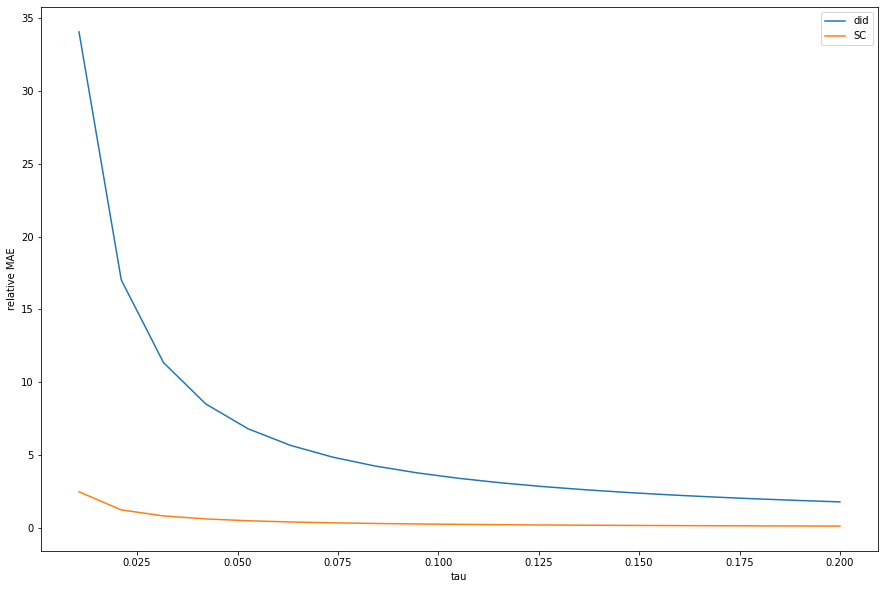

In [ ]:
plt.plot(taus, mae_did, label = "did")
plt.plot(taus, mae_sc, label = "SC")
plt.xlabel("tau")
plt.ylabel("relative MAE")
plt.legend()

In [ ]:
exp.args.num_trials = 1
exp.args.tau = 0.1
exp.validation_procedure_output_v2()

100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

num features selected after correction:  92
R2 SC:  0.5753561325546388


,Method,Relative MAE,Conf_int acc,Average conf_int width
0,DiD,3.5843,0.0000,0.1642
1,SC,0.2616,0.9500,0.0262
